In [1]:
%load_ext autoreload
%autoreload 2
from multiprocessing import Pool
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.ticker import FormatStrFormatter as fsf
from matplotlib.ticker import ScalarFormatter as sf
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes as zia
from plots.mpltoolkit import (named_colors, mpl_loc,
    fancy_legend, load_mpl_presets, append_axes, markers, append_axes)
import vice
# from vice.yields.presets import JW20
import numpy as np
import math as m
import random
import sys
sys.path.append("..")
from src.utils import linear_exponential, exponential, chisquared
# from gsefit import constant_then_exponential
load_mpl_presets()
print(sys.version_info)

/Users/jamesjohnson/Work/Research/VICErepos/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=10, micro=4, releaselevel='final', serial=0)


In [2]:
raw = np.genfromtxt("../mocksamples/fiducial.dat")
mock = vice.dataframe({})
mock["[fe/h]"] = raw[:, 0]
mock["[fe/h]_err"] = raw[:, 1]
mock["[o/fe]"] = raw[:, 2]
mock["[o/fe]_err"] = raw[:, 3]
mock["age"] = [10**_ for _ in raw[:, 4]]
mock["age_err"] = [a * b * m.log(10) for a, b in zip(mock["age"], raw[:, 5])]

/var/home/johnson.7419.local/VICE/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: func
  warnings.warn("""\
/home/johnson.7419/tmp/ipykernel_19375/661926755.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


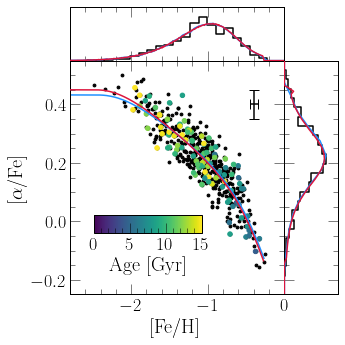

In [67]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("[Fe/H]")
ax.set_ylabel(r"[$\alpha$/Fe]")
ax.set_xlim([-2.8, 0])
ax.set_ylim([-0.25, 0.55])

kwargs = {
    "c": named_colors()["black"],
    "s": 8
}
ax.scatter(mock["[fe/h]"], mock["[o/fe]"], **kwargs)
kwargs["s"] = 20
kwargs["c"] = mock["age"]
kwargs["cmap"] = "viridis"
kwargs["vmin"] = 0
kwargs["vmax"] = 15
sc = ax.scatter(mock["[fe/h]"], mock["[o/fe]"], **kwargs)
cbar_ax = fig.add_axes([0.27, 0.32, 0.3, 0.05])
cbar = plt.colorbar(sc, cax = cbar_ax, pad = 0, orientation = "horizontal")
cbar.set_label("Age [Gyr]", labelpad = 3)
cbar.set_ticks(range(0, 16, 5))
ax.errorbar(-0.4, 0.4, xerr = 0.05, yerr = 0.05, c = named_colors()["black"])

top = fig.add_axes([0.1, 0.9, 0.8, 0.1])
right = fig.add_axes([0.9, 0.1, 0.1, 0.8])
plt.setp(top.get_xticklabels(), visible = False)
plt.setp(top.get_yticklabels(), visible = False)
plt.setp(right.get_xticklabels(), visible = False)
plt.setp(right.get_yticklabels(), visible = False)
top.set_xlim(ax.get_xlim())
top.set_ylim([0, 1.5])
top.tick_params(axis = "y", which = "both", left = False, right = False)
right.set_xlim([0, 5])
right.set_ylim(ax.get_ylim())
right.tick_params(axis = "x", which = "both", bottom = False, top = False)

kwargs = {
    "bins": 25,
    "range": ax.get_xlim()
}
# feh_counts, _ = np.histogram(mock["[fe/h]"], density = False, **kwargs)
feh_dist, feh_bins = np.histogram(mock["[fe/h]"], density = True, **kwargs)
# idx = feh_dist.tolist().index(max(feh_dist))
# norm = feh_counts[idx] / feh_dist[idx]
# feh_err = [np.sqrt(_) / norm for _ in feh_counts]
top.step(feh_bins[:-1], feh_dist, where = "post", c = named_colors()["black"])
# centers = [(a + b) / 2 for a, b in zip(feh_bins[:-1], feh_bins[1:])]
# top.errorbar(centers, feh_dist, yerr = feh_err, c = named_colors()["black"], linestyle = "None", capsize = 2)

kwargs["range"] = ax.get_ylim()
# afe_counts, _ = np.histogram(mock["[o/fe]"], density = False, **kwargs)
afe_dist, afe_bins = np.histogram(mock["[o/fe]"], density = True, **kwargs)
# idx = afe_dist.tolist().index(max(afe_dist))
# norm = afe_counts[idx] / afe_dist[idx]
# afe_err = [np.sqrt(_) / norm for _ in afe_counts]
right.step(afe_dist, afe_bins[:-1], where = "pre", c = named_colors()["black"])
# centers = [(a + b) / 2 for a, b in zip(afe_bins[:-1], afe_bins[1:])]
# right.errorbar(afe_dist, centers, xerr = afe_err, c = named_colors()["black"], linestyle = "None", capsize = 2)

with vice.output("../mocksamples/fiducial") as true:
    kwargs = {
        "c": named_colors()["crimson"],
        "zorder": 1000
    }
    ax.plot(true.history["[fe/h]"], true.history["[o/fe]"], **kwargs)
    xvals = [(a + b) / 2 for a, b in zip(true.mdf["bin_edge_left"], true.mdf["bin_edge_right"])]
    top.plot(xvals, true.mdf["dn/d[fe/h]"], **kwargs)
    right.plot(true.mdf["dn/d[o/fe]"], xvals, **kwargs)
    
bf_duration = 9.47
with vice.singlezone(name = "./bestfit") as sz:
    sz.elements = ["fe", "o"]
    sz.func = exponential()
    sz.func.timescale = 1.85
    sz.mode = "ifr"
    sz.dt = bf_duration / 1000
    sz.Mg0 = 0
#     sz.nthreads = 2
    sz.eta = 9.91
    sz.tau_star = 14.11
    vice.yields.ccsne.settings['o'] = 0.01
    vice.yields.sneia.settings['o'] = 0
    vice.yields.ccsne.settings['fe'] = 8.33e-4
    vice.yields.sneia.settings['fe'] = 1.04e-3
    bfout = sz.run(np.linspace(0, bf_duration, 1001), overwrite = True, capture = True)
    
kwargs = {"c": named_colors()["dodgerblue"]}
ax.plot(bfout.history["[fe/h]"], bfout.history["[o/fe]"], **kwargs)
xvals = [(a + b) / 2 for a, b in zip(bfout.mdf["bin_edge_left"], bfout.mdf["bin_edge_right"])]
top.plot(xvals, bfout.mdf["dn/d[fe/h]"], **kwargs)
right.plot(bfout.mdf["dn/d[o/fe]"], xvals, **kwargs)

plt.tight_layout()
plt.subplots_adjust(right = 0.8, top = 0.8)
top.set_position([
    ax.get_position().x0,
    ax.get_position().y1,
    ax.get_position().x1 - ax.get_position().x0,
    0.15
])
right.set_position([
    ax.get_position().x1,
    ax.get_position().y0,
    0.15,
    ax.get_position().y1 - ax.get_position().y0
])
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("../paper/fiducial_mock_afe_feh.%s" % (ext), **kwargs)
plt.show()

In [4]:
cosmological_age = 13.2
quantities = list(filter(lambda _: not _.endswith("_err"), mock.keys()))
sub = vice.dataframe(mock.todict())
sub["age"] = [m.log10(_) for _ in sub["age"]]
sub["age_err"] = [0.1 if not m.isnan(_) else float("nan") for _ in sub["age"]]
sample = np.array([sub[key] for key in quantities]).T
errors = np.array([sub["%s_err" % (key)] for key in quantities]).T
model = len(bfout.history["time"]) * [None]
for i in range(len(model)):
    model[i] = len(quantities) * [0.]
    for j in range(len(quantities)):
        if quantities[j] == "age":
            model[i][j] = m.log10(bfout.history["lookback"][i] + cosmological_age - bf_duration)
#             model[i][j] = bfout.history["lookback"][i] + cosmological_age - bf_duration
        else:
            model[i][j] = bfout.history[quantities[j]][i]
model = model[1:] # chop off the -inf [Fe/H] predicted at t = 0
weights = bfout.history["sfr"][1:]
N = 0
for i in range(len(sample)):
    for j in range(len(sample[i])):
        if not m.isnan(sample[i][j]): N += 1
chisq = chisquared(sample, errors, model, weights)
print(chisq / (N - 6))

0.5548071490509872


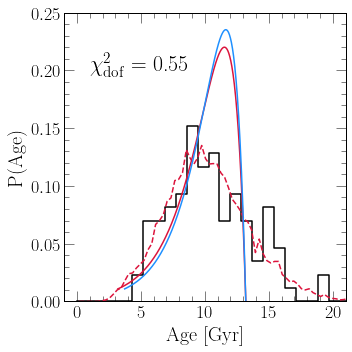

In [69]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Age [Gyr]")
ax.set_ylabel("P(Age)")
ax.set_xlim([-1, 21])
ax.set_ylim([0, 0.25])
# ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2])

kwargs = {
    "bins": 35,
    "range": [0, 30]
}
# age_counts, _ = np.histogram(mock["age"], density = False, **kwargs)
age_dist, age_bins = np.histogram(mock["age"], density = True, **kwargs)
# idx = age_counts.tolist().index(max(age_counts))
# norm = age_counts[idx] / age_dist[idx]
# age_err = [np.sqrt(_) / norm for _ in age_counts]
ax.step(age_bins[:-1], age_dist, where = "post", c = named_colors()["black"])
# centers = [(a + b) / 2 for a, b in zip(age_bins[:-1], age_bins[1:])]
# print(len(centers))
# print(len(age_dist))
# ax.errorbar(centers, age_dist, yerr = age_err, linestyle = "None", capsize = 2, c = named_colors()["black"])

with vice.output("../mocksamples/fiducial") as true:
    diff = 13.2 - true.history["time"][-1]
    xvals = [_ + diff for _ in true.history["lookback"]]
    norm = sum(true.history["sfr"]) * (true.history["time"][1] - true.history["time"][0])
    yvals = [_ / norm for _ in true.history["sfr"]]
    ax.plot(xvals, yvals, c = named_colors()["crimson"])
    
    totsfr = sum(true.history["sfr"])
    sfrfrac = [_ / totsfr for _ in true.history["sfr"]]
    indeces = np.random.choice(list(range(len(sfrfrac))), p = sfrfrac, size = int(1e4))
    resampled = [diff + true.history["lookback"][indeces[_]] for _ in range(len(indeces))]
    resampled = [10**(m.log10(_) + np.random.normal(scale = 0.1)) for _ in resampled]
    dist, bins = np.histogram(resampled, bins = 100, range = [0, 30], density = True)
    xvals = [(a + b) / 2 for a, b in zip(bins[1:], bins[:-1])]
    ax.plot(xvals, dist, c = named_colors()["crimson"], linestyle = '--')
    
with vice.output("./bestfit") as bfout:
    diff = 13.2 - bfout.history["time"][-1]
    xvals = [_ + diff for _ in bfout.history["lookback"]]
    norm = sum(bfout.history["sfr"]) * (bfout.history["time"][1] - bfout.history["time"][0])
    yvals = [_ / norm for _ in bfout.history["sfr"]]
    ax.plot(xvals, yvals, c = named_colors()["dodgerblue"])
    
ax.text(1, 0.20, r"$\chi^2_\text{dof}$ = 0.55", fontsize = 22)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("../paper/fiducial_mock_agedist.%s" % (ext), **kwargs)
plt.show()

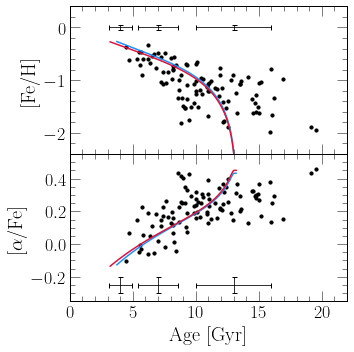

In [71]:
fig = plt.figure()
top = fig.add_subplot(211)
bottom = fig.add_subplot(212)
for ax in [top, bottom]:
#     ax.set_xscale("log")
    ax.set_xlim([0, 22])
plt.setp(top.get_xticklabels(which = "both"), visible = False)
# bottom.xaxis.set_major_formatter(fsf("%g"))
# bottom.xaxis.set_minor_formatter(fsf("%g"))
top.set_ylim([-2.4, 0.4])
bottom.set_ylim([-0.35, 0.55])
bottom.set_yticks([-0.2, 0, 0.2, 0.4])
bottom.set_xlabel("Age [Gyr]")
bottom.set_ylabel(r"[$\alpha$/Fe]")
top.set_ylabel("[Fe/H]")

kwargs = {
    "c": named_colors()["black"],
    "s": 10
}
top.scatter(mock["age"], mock["[fe/h]"], **kwargs)
bottom.scatter(mock["age"], mock["[o/fe]"], **kwargs)

# bottom.set_xticks(range(2, 10), [str(_) if _ == 2 or _ == 5 else "" for _ in range(2, 10)], minor = True)
# bottom.set_xticks([10, 20], minor = False)

# ageval = 4
# age_err = [[ageval - 10**(m.log10(ageval - 0.1 * ageval * m.log(10)))],
#     [10**(m.log10(ageval + 0.1 * ageval * m.log(10))) - ageval]]
# bottom.errorbar(ageval, 0.4, xerr = age_err, yerr = 0.05, c = named_colors()["black"])
# top.errorbar(ageval, -2, xerr = age_err, yerr = 0.05, c = named_colors()["black"])

agevals = [4, 7, 13]
for age in agevals:
    age_err = [[age - 10**(m.log10(age - 0.1 * age * m.log(10)))],
        [10**(m.log10(age + 0.1 * age * m.log(10))) - age]]
    bottom.errorbar(age, -0.25, xerr = age_err, yerr = 0.05, c = named_colors()["black"], linewidth = 0.8,
        capsize = 2.5)
    top.errorbar(age, 0, xerr = age_err, yerr = 0.05, c = named_colors()["black"], linewidth = 0.8,
        capsize = 2.5)

with vice.output("../mocksamples/fiducial") as true:
    diff = 13.2 - true.history["time"][-1]
    xvals = [_ + diff for _ in true.history["lookback"]]
    top.plot(xvals, true.history["[fe/h]"], c = named_colors()["crimson"], zorder = 1000)
    bottom.plot(xvals, true.history["[o/fe]"], c = named_colors()["crimson"], zorder = 1000)
    
with vice.output("./bestfit") as bfout:
    diff = 13.2 - bfout.history["time"][-1]
    xvals = [_ + diff for _ in bfout.history["lookback"]]
    top.plot(xvals, bfout.history["[fe/h]"], c = named_colors()["dodgerblue"])
    bottom.plot(xvals, bfout.history["[o/fe]"], c = named_colors()["dodgerblue"])

plt.tight_layout()
plt.subplots_adjust(hspace = 0, left = 0.2)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("../paper/fiducial_mock_amr.%s" % (ext), **kwargs)
plt.show()

In [3]:
true_values = [2, 10, 15, 10, 0.0008, 0.0011]
# for each sample size, the re-derived value, +error, and -error, in that order
rederived_samplesize = {
    20: [
        [2.55, 0.75, 0.45],
        [8.39, 1.11, 1.30],
        [14.35, 5.56, 3.32],
        [10.60, 1.65, 1.09],
        [0.00079, 0.00012, 0.00019],
        [0.00136, 0.00033, 0.00023]
    ],
    50: [
        [2.13, 0.42, 0.36],
        [10.39, 0.80, 0.76],
        [13.75, 2.79, 2.38],
        [11.25, 1.37, 1.76],
        [0.00083, 0.00006, 0.00006],
        [0.00095, 0.00014, 0.00014]
    ],
    100: [
        [2.06, 0.27, 0.26],
        [9.88, 0.64, 0.62],
        [15.06, 2.00, 1.79],
        [11.52, 1.06, 1.30],
        [0.00081, 0.00004, 0.00004],
        [0.00108, 0.00009, 0.00009]
    ],
    200: [
        [2.10, 0.18, 0.17],
        [10.11, 0.45, 0.43],
        [14.61, 1.34, 1.18],
        [10.60, 1.07, 0.86],
        [0.00077, 0.00003, 0.00003],
        [0.00114, 0.00007, 0.00007]
    ],
    500: [
        [1.85, 0.11, 0.11],
        [9.91, 0.29, 0.29],
        [14.11, 0.83, 0.79],
        [9.47, 0.53, 0.61],
        [8.3e-4, 0.20e-4, 0.21e-4],
        [1.04e-3, 0.05e-3, 0.05e-3]
    ],
    1000: [
        [2.05, 0.09, 0.08],
        [9.72, 0.20, 0.20],
        [14.62, 0.57, 0.56],
        [9.83, 0.38, 0.39],
        [0.00081, 0.00001, 0.00001],
        [0.00114, 0.00003, 0.00003]
    ],
    2000: [
        [2.00, 0.05, 0.05],
        [10.26, 0.15, 0.15],
        [15.82, 0.44, 0.42],
        [10.30, 0.25, 0.32],
        [0.00080, 0.00001, 0.00001],
        [0.00109, 0.00002, 0.00002]
    ]
}

rederived_abundanceprecision = {
    0.01: [
        [1.89, 0.10, 0.10],
        [10.25, 0.28, 0.28],
        [15.06, 0.52, 0.47],
        [9.70, 0.51, 0.59],
        [0.0008, 0.00001, 0.00001],
        [0.00109, 0.00002, 0.00002]
    ],
    0.02: [
        [1.92, 0.10, 0.09],
        [10.10, 0.25, 0.25],
        [14.71, 0.56, 0.55],
        [9.79, 0.45, 0.40],
        [0.00081, 0.00001, 0.00001],
        [0.00108, 0.00002, 0.00003]
    ],
    0.05: [
        [1.85, 0.11, 0.11],
        [9.91, 0.29, 0.29],
        [14.11, 0.83, 0.79],
        [9.47, 0.53, 0.61],
        [8.3e-4, 0.20e-4, 0.21e-4],
        [1.04e-3, 0.05e-3, 0.05e-3]
    ],
    0.1: [
        [2.00, 0.13, 0.12],
        [9.88, 0.31, 0.33],
        [13.39, 1.02, 1.02],
        [11.10, 1.00, 0.84],
        [0.00085, 0.00004, 0.00003],
        [0.00101, 0.00007, 0.00007]
    ],
    0.2: [
        [2.22, 0.21, 0.21],
        [9.83, 0.58, 0.67],
        [18.21, 2.19, 2.02],
        [10.32, 1.05, 0.67],
        [0.00087, 0.00007, 0.00007],
        [0.00105, 0.00014, 0.00014]
    ],
    0.5: [
        [2.73, 0.82, 0.60],
        [10.05, 1.22, 1.26],
        [12.52, 3.75, 3.35],
        [9.00, 1.26, 0.95],
        [0.00075, 0.00018, 0.00016],
        [0.00112, 0.00031, 0.00031]
    ]
}

rederived_ageprecision = {
    0.02: [
        [2.08, 0.09, 0.08],
        [9.84, 0.24, 0.26],
        [14.69, 0.50, 0.46],
        [10.41, 0.47, 0.41],
        [0.00081, 0.00002, 0.00002],
        [0.00111, 0.00005, 0.00004]
    ],
    0.05: [
        [1.96, 0.11, 0.11],
        [9.88, 0.32, 0.30],
        [15.70, 0.71, 0.68],
        [9.95, 0.63, 0.53],
        [0.0008, 0.00002, 0.00002],
        [0.00111, 0.00005, 0.00004]
    ],
    0.1: [
        [1.85, 0.11, 0.11],
        [9.91, 0.29, 0.29],
        [14.11, 0.83, 0.79],
        [9.47, 0.53, 0.61],
        [8.3e-4, 0.20e-4, 0.21e-4],
        [1.04e-3, 0.05e-3, 0.05e-3]
    ],
    0.2: [
        [2.20, 0.18, 0.17],
        [9.83, 0.28, 0.27],
        [15.19, 1.11, 1.11],
        [10.76, 0.85, 0.93],
        [0.0008, 0.00002, 0.00002],
        [0.00111, 0.00005, 0.00004]
    ],
    0.5: [
        [2.25, 0.20, 0.25],
        [9.86, 0.28, 0.30],
        [16.24, 1.44, 1.62],
        [11.38, 1.00, 1.34],
        [0.0008, 0.00002, 0.00002],
        [0.0011, 0.00005, 0.00005]
    ],
    1.0: [
        [1.69, 0.35, 0.32],
        [9.53, 0.29, 0.29],
        [12.38, 2.27, 2.08],
        [8.66, 1.86, 1.74],
        [0.00083, 0.00003, 0.00003],
        [0.00115, 0.00006, 0.00006]
    ]
}

rederived_agefrac = {
    0.0: [
        [1.65, 0.55, 0.37],
        [9.39, 0.30, 0.29],
        [11.80, 3.36, 2.44],
        [7.35, 2.62, 1.74],
        [0.00083, 0.00004, 0.00004],
        [0.00119, 0.00008, 0.00007]
    ],
    0.1: [
        [1.75, 0.16, 0.17],
        [10.06, 0.29, 0.28],
        [13.65, 1.22, 1.12],
        [8.84, 0.87, 0.87],
        [0.00084, 0.00002, 0.00002],
        [0.00106, 0.00005, 0.00005]
    ],
    0.2: [
        [1.85, 0.11, 0.11],
        [9.91, 0.29, 0.29],
        [14.11, 0.83, 0.79],
        [9.47, 0.53, 0.61],
        [8.3e-4, 0.20e-4, 0.21e-4],
        [1.04e-3, 0.05e-3, 0.05e-3]
    ],
    0.3: [
        [1.94, 0.11, 0.10],
        [9.80, 0.27, 0.28],
        [14.26, 0.74, 0.67],
        [9.89, 0.54, 0.48],
        [0.0008, 0.00002, 0.00002],
        [0.0011, 0.00004, 0.00004]
    ],
    0.4: [
        [1.91, 0.09, 0.10],
        [10.07, 0.32, 0.30],
        [16.79, 0.81, 0.83],
        [10.34, 0.61, 0.50],
        [0.00078, 0.00002, 0.00002],
        [0.00112, 0.00005, 0.00005]
    ],
    0.5: [
        [2.00, 0.10, 0.10],
        [10.16, 0.30, 0.29],
        [15.46, 0.70, 0.69],
        [9.83, 0.48, 0.40],
        [0.00078, 0.00002, 0.00002],
        [0.00112, 0.00005, 0.00004]
    ],
    0.6: [
        [2.18, 0.09, 0.09],
        [9.65, 0.27, 0.25],
        [14.25, 0.67, 0.64],
        [10.49, 0.44, 0.37],
        [0.00078, 0.00002, 0.00002],
        [0.00115, 0.00004, 0.00004]
    ],
    0.7: [
        [1.99, 0.08, 0.08],
        [9.81, 0.28, 0.27],
        [14.92, 0.68, 0.62],
        [10.25, 0.46, 0.37],
        [0.00081, 0.00002, 0.00002],
        [0.00108, 0.00004, 0.00004]
    ],
    0.8: [
        [2.06, 0.09, 0.09],
        [9.53, 0.29, 0.26],
        [15.18, 0.63, 0.59],
        [9.76, 0.36, 0.33],
        [0.00079, 0.00002, 0.00002],
        [0.00115, 0.00005, 0.00005]
    ],
    0.9: [
        [1.93, 0.08, 0.08],
        [10.41, 0.31, 0.31],
        [16.23, 0.73, 0.70],
        [10.03, 0.39, 0.33],
        [0.00077, 0.00002, 0.00002],
        [0.00114, 0.00004, 0.00004]
    ],
    1.0: [
        [2.13, 0.09, 0.09],
        [9.44, 0.28, 0.27],
        [15.67, 0.64, 0.60],
        [10.21, 0.35, 0.31],
        [0.0008, 0.00002, 0.00002],
        [0.00115, 0.00005, 0.00005]
    ]
}

In [4]:
units = ["Gyr", "", "Gyr", "Gyr", "", ""]
with open("../paper/draft1/mocksamples.tablebody.tex", 'w') as out:
    out.write(r"""
{\renewcommand{\arraystretch}{1.8}
\begin{table*}
\caption{
Known (top row) and recovered best-fit values of the evolutionary parameters
used to generate our mock data samples (from left to right): the variation
of our fiducial mock sample, the e-folding timescale of the infall
history~$\tau_\text{in}$, the outflow mass-loading factor~$\eta$, the SFE
timescale~$\tau_\star$, the duration of star formation~$\tau_\text{tot}$,
the IMF-averaged Fe yield from CCSNe~\yfecc, and the DTD-integrated Fe yield
from SNe Ia~\yfeia.
Each variation has the same evolutionary parameters in the GCE model, but
has either a different sample size (top block), measurement uncertainty
in~\feh~and~\afe~abundances (top-middle block), measurement uncertainty
in~$\log_{10}(\text{age})$ (bottom-middle block), or fraction of the
sample with available age measurements (bottom block).
The values taken in the fiducial mock sample are marked in bold.
We provide illustrations of the accuracy and precision of these fits in
Figs.~\ref{fig:accuracy} and~\ref{fig:precision}, respectively.
}
\begin{tabularx}{\textwidth}{l @{\extracolsep{\fill}} c c c c c c}
\hline
Mock Sample & $\tau_\text{in}$ & $\eta$ & $\tau_\star$ & $\tau_\text{tot}$ &
\yfecc & \yfeia
\\
\hline
\hline
""")
    
    out.write("\\null &\n")
    for i in range(len(true_values) - 2): out.write("%g %s &\n" % (true_values[i], units[i]))
    out.write("\\scinote{%.2f}{-4} &\n" % (1e4 * true_values[-2]))
    out.write("\\scinote{%.2f}{-3}\n" % (1e3 * true_values[-1]))
    out.write(r"""\\
\hline
\hline
""")
    
    for samplesize in rederived_samplesize.keys():
        if samplesize == 500:
            out.write("$\\bm{N = %d}$ &\n" % (samplesize))
        else:
            out.write("$N = %d$ &\n" % (samplesize))
        rederived = rederived_samplesize[samplesize]
        for i in range(len(rederived) - 2):
            match [rederived[i][1] == rederived[i][2], samplesize]:
                case [True, 500]:
                    out.write("$\\bm{%.2f \pm %.2f}$ %s &\n" % (rederived[i][0], rederived[i][1], units[i]))
                case [False, 500]:
                    u = "\\textbf{%s}" % (units[i]) if units[i] != "" else ""
                    out.write("$\\bm{%.2f^{+%.2f}_{-%.2f}}$ %s &\n" % (rederived[i][0],
                        rederived[i][1], rederived[i][2], u))
                case [True, s]:
                    out.write("$%.2f \pm %.2f$ %s &\n" % (rederived[i][0], rederived[i][1], units[i]))
                case [False, s]:
                    out.write("$%.2f^{+%.2f}_{-%.2f}$ %s &\n" % (rederived[i][0], rederived[i][1],
                        rederived[i][2], units[i]))
        match [rederived[-2][1] == rederived[-2][2], samplesize]:
            case [True, 500]:
                out.write("$\\bm{\\scinote{(%.2f \pm %.2f)}{-4}}$ &\n" % (1e4 * rederived[-2][0],
                    1e4 * rederived[-2][1]))
            case [False, 500]:
                out.write("$\\bm{\\scinote{%.2f^{+%.2f}_{-%.2f}}{-4}}$ &\n" % (1e4 * rederived[-2][0],
                    1e4 * rederived[-2][1], 1e4 * rederived[-2][2]))
            case [True, s]:
                out.write("$\\scinote{(%.2f \pm %.2f)}{-4}$ &\n" % (1e4 * rederived[-2][0],
                    1e4 * rederived[-2][1]))
            case [False, s]:
                out.write("$\\scinote{%.2f^{+%.2f}_{-%.2f}}{-4}$ &\n" % (1e4 * rederived[-2][0],
                    1e4 * rederived[-2][1], 1e4 * rederived[-2][2]))
        match [rederived[-1][1] == rederived[-1][2], samplesize]:
            case [True, 500]:
                out.write("$\\bm{\\scinote{(%.2f \pm %.2f)}{-3}}$\n" % (1e3 * rederived[-1][0],
                    1e3 * rederived[-1][1]))
            case [False, 500]:
                out.write("$\\bm{\\scinote{%.2f^{+%.2f}_{-%.2f}}{-3}}$\n" % (1e3 * rederived[-1][0],
                    1e3 * rederived[-1][1], 1e3 * rederived[-1][2]))
            case [True, s]:
                out.write("$\\scinote{(%.2f \pm %.2f)}{-3}$\n" % (1e3 * rederived[-1][0],
                    1e3 * rederived[-1][1]))
            case [False, s]:
                out.write("$\\scinote{%.2f^{+%.2f}_{-%.2f}}{-3}$\n" % (1e3 * rederived[-1][0],
                    1e3 * rederived[-1][1], 1e3 * rederived[-1][2]))
                
        out.write("\\\\\n")
    out.write(r"""\hline
\hline
""")
    
    for ab_precision in rederived_abundanceprecision.keys():
        if ab_precision == 0.05:
            out.write("$\\bm{\\sigma_\\textbf{[X/Y]} = %g}$ &\n" % (ab_precision))
        else:
            out.write("$\\sigma_\\text{[X/Y]} = %g$ &\n" % (ab_precision))
        rederived = rederived_abundanceprecision[ab_precision]
        for i in range(len(rederived) - 2):
            match [rederived[i][1] == rederived[i][2], ab_precision]:
                case [True, 0.05]:
                    out.write("$\\bm{%.2f \pm %.2f}$ %s &\n" % (rederived[i][0], rederived[i][1], units[i]))
                case [False, 0.05]:
                    u = "\\textbf{%s}" % (units[i]) if units[i] != "" else ""
                    out.write("$\\bm{%.2f^{+%.2f}_{-%.2f}}$ %s &\n" % (rederived[i][0],
                        rederived[i][1], rederived[i][2], u))
                case [True, s]:
                    out.write("$%.2f \pm %.2f$ %s &\n" % (rederived[i][0], rederived[i][1], units[i]))
                case [False, s]:
                    out.write("$%.2f^{+%.2f}_{-%.2f}$ %s &\n" % (rederived[i][0], rederived[i][1],
                        rederived[i][2], units[i]))
        match [rederived[-2][1] == rederived[-2][2], ab_precision]:
            case [True, 0.05]:
                out.write("$\\bm{\\scinote{(%.2f \pm %.2f)}{-4}}$ &\n" % (1e4 * rederived[-2][0],
                    1e4 * rederived[-2][1]))
            case [False, 0.05]:
                out.write("$\\bm{\\scinote{%.2f^{+%.2f}_{-%.2f}}{-4}}$ &\n" % (1e4 * rederived[-2][0],
                    1e4 * rederived[-2][1], 1e4 * rederived[-2][2]))
            case [True, s]:
                out.write("$\\scinote{(%.2f \pm %.2f)}{-4}$ &\n" % (1e4 * rederived[-2][0],
                    1e4 * rederived[-2][1]))
            case [False, s]:
                out.write("$\\scinote{%.2f^{+%.2f}_{-%.2f}}{-4}$ &\n" % (1e4 * rederived[-2][0],
                    1e4 * rederived[-2][1], 1e4 * rederived[-2][2]))
        match [rederived[-1][1] == rederived[-1][2], ab_precision]:
            case [True, 0.05]:
                out.write("$\\bm{\\scinote{(%.2f \pm %.2f)}{-3}}$\n" % (1e3 * rederived[-1][0],
                    1e3 * rederived[-1][1]))
            case [False, 0.05]:
                out.write("$\\bm{\\scinote{%.2f^{+%.2f}_{-%.2f}}{-3}}$\n" % (1e3 * rederived[-1][0],
                    1e3 * rederived[-1][1], 1e3 * rederived[-1][2]))
            case [True, s]:
                out.write("$\\scinote{(%.2f \pm %.2f)}{-3}$\n" % (1e3 * rederived[-1][0],
                    1e3 * rederived[-1][1]))
            case [False, s]:
                out.write("$\\scinote{%.2f^{+%.2f}_{-%.2f}}{-3}$\n" % (1e3 * rederived[-1][0],
                    1e3 * rederived[-1][1], 1e3 * rederived[-1][2]))
                
        out.write("\\\\\n")
    out.write(r"""\hline
\hline
""")
    
    
    for age_precision in rederived_ageprecision.keys():
        if age_precision == 0.1:
            out.write("$\\bm{\\sigma_{\\log_{10}(\\textbf{age})} = %g}$ &\n" % (age_precision))
        else:
            out.write("$\\sigma_{\\log_{10}(\\text{age})} = %g$ &\n" % (age_precision))
        rederived = rederived_ageprecision[age_precision]
        for i in range(len(rederived) - 2):
            match [rederived[i][1] == rederived[i][2], age_precision]:
                case [True, 0.1]:
                    out.write("$\\bm{%.2f \pm %.2f}$ %s &\n" % (rederived[i][0], rederived[i][1], units[i]))
                case [False, 0.1]:
                    u = "\\textbf{%s}" % (units[i]) if units[i] != "" else ""
                    out.write("$\\bm{%.2f^{+%.2f}_{-%.2f}}$ %s &\n" % (rederived[i][0],
                        rederived[i][1], rederived[i][2], u))
                case [True, s]:
                    out.write("$%.2f \pm %.2f$ %s &\n" % (rederived[i][0], rederived[i][1], units[i]))
                case [False, s]:
                    out.write("$%.2f^{+%.2f}_{-%.2f}$ %s &\n" % (rederived[i][0], rederived[i][1],
                        rederived[i][2], units[i]))
        match [rederived[-2][1] == rederived[-2][2], age_precision]:
            case [True, 0.1]:
                out.write("$\\bm{\\scinote{(%.2f \pm %.2f)}{-4}}$ &\n" % (1e4 * rederived[-2][0],
                    1e4 * rederived[-2][1]))
            case [False, 0.1]:
                out.write("$\\bm{\\scinote{%.2f^{+%.2f}_{-%.2f}}{-4}}$ &\n" % (1e4 * rederived[-2][0],
                    1e4 * rederived[-2][1], 1e4 * rederived[-2][2]))
            case [True, s]:
                out.write("$\\scinote{(%.2f \pm %.2f)}{-4}$ &\n" % (1e4 * rederived[-2][0],
                    1e4 * rederived[-2][1]))
            case [False, s]:
                out.write("$\\scinote{%.2f^{+%.2f}_{-%.2f}}{-4}$ &\n" % (1e4 * rederived[-2][0],
                    1e4 * rederived[-2][1], 1e4 * rederived[-2][2]))
        match [rederived[-1][1] == rederived[-1][2], age_precision]:
            case [True, 0.1]:
                out.write("$\\bm{\\scinote{(%.2f \pm %.2f)}{-3}}$\n" % (1e3 * rederived[-1][0],
                    1e3 * rederived[-1][1]))
            case [False, 0.1]:
                out.write("$\\bm{\\scinote{%.2f^{+%.2f}_{-%.2f}}{-3}}$\n" % (1e3 * rederived[-1][0],
                    1e3 * rederived[-1][1], 1e3 * rederived[-1][2]))
            case [True, s]:
                out.write("$\\scinote{(%.2f \pm %.2f)}{-3}$\n" % (1e3 * rederived[-1][0],
                    1e3 * rederived[-1][1]))
            case [False, s]:
                out.write("$\\scinote{%.2f^{+%.2f}_{-%.2f}}{-3}$\n" % (1e3 * rederived[-1][0],
                    1e3 * rederived[-1][1], 1e3 * rederived[-1][2]))
                
        out.write("\\\\\n")
    out.write(r"""\hline
\hline
""")
    
    
    
    for agefrac in rederived_agefrac.keys():
        if agefrac == 0.2:
            out.write("$\\bm{f_\\textbf{age} = %g}$ &\n" % (agefrac))
        else:
            out.write("$f_\\text{age} = %g$ &\n" % (agefrac))
        rederived = rederived_agefrac[agefrac]
        for i in range(len(rederived) - 2):
            match [rederived[i][1] == rederived[i][2], agefrac]:
                case [True, 0.2]:
                    out.write("$\\bm{%.2f \pm %.2f}$ %s &\n" % (rederived[i][0], rederived[i][1], units[i]))
                case [False, 0.2]:
                    u = "\\textbf{%s}" % (units[i]) if units[i] != "" else ""
                    out.write("$\\bm{%.2f^{+%.2f}_{-%.2f}}$ %s &\n" % (rederived[i][0],
                        rederived[i][1], rederived[i][2], u))
                case [True, s]:
                    out.write("$%.2f \pm %.2f$ %s &\n" % (rederived[i][0], rederived[i][1], units[i]))
                case [False, s]:
                    out.write("$%.2f^{+%.2f}_{-%.2f}$ %s &\n" % (rederived[i][0], rederived[i][1],
                        rederived[i][2], units[i]))
        match [rederived[-2][1] == rederived[-2][2], agefrac]:
            case [True, 0.2]:
                out.write("$\\bm{\\scinote{(%.2f \pm %.2f)}{-4}}$ &\n" % (1e4 * rederived[-2][0],
                    1e4 * rederived[-2][1]))
            case [False, 0.2]:
                out.write("$\\bm{\\scinote{%.2f^{+%.2f}_{-%.2f}}{-4}}$ &\n" % (1e4 * rederived[-2][0],
                    1e4 * rederived[-2][1], 1e4 * rederived[-2][2]))
            case [True, s]:
                out.write("$\\scinote{(%.2f \pm %.2f)}{-4}$ &\n" % (1e4 * rederived[-2][0],
                    1e4 * rederived[-2][1]))
            case [False, s]:
                out.write("$\\scinote{%.2f^{+%.2f}_{-%.2f}}{-4}$ &\n" % (1e4 * rederived[-2][0],
                    1e4 * rederived[-2][1], 1e4 * rederived[-2][2]))
        match [rederived[-1][1] == rederived[-1][2], agefrac]:
            case [True, 0.2]:
                out.write("$\\bm{\\scinote{(%.2f \pm %.2f)}{-3}}$\n" % (1e3 * rederived[-1][0],
                    1e3 * rederived[-1][1]))
            case [False, 0.2]:
                out.write("$\\bm{\\scinote{%.2f^{+%.2f}_{-%.2f}}{-3}}$\n" % (1e3 * rederived[-1][0],
                    1e3 * rederived[-1][1], 1e3 * rederived[-1][2]))
            case [True, s]:
                out.write("$\\scinote{(%.2f \pm %.2f)}{-3}$\n" % (1e3 * rederived[-1][0],
                    1e3 * rederived[-1][1]))
            case [False, s]:
                out.write("$\\scinote{%.2f^{+%.2f}_{-%.2f}}{-3}$\n" % (1e3 * rederived[-1][0],
                    1e3 * rederived[-1][1], 1e3 * rederived[-1][2]))
                
        out.write("\\\\\n")
    out.write(r"""\hline
\hline
""")
    

    out.write(r"""\end{tabularx}
\label{tab:recovered_values}
\end{table*}
}
""")
    
    out.close()

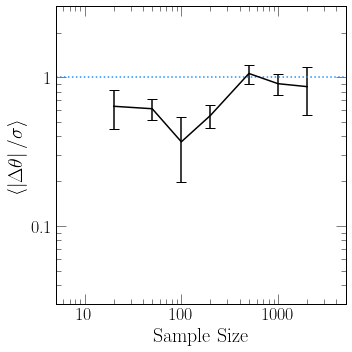

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xscale("log")
ax.set_yscale("log")
ax.xaxis.set_major_formatter(fsf("%g"))
ax.yaxis.set_major_formatter(fsf("%g"))
ax.set_xlabel("Sample Size")
ax.set_ylabel(r"$\langle\left|\Delta\theta\right|/\sigma\rangle$")
ax.set_xlim([5, 5000])
ax.set_ylim([0.03, 3])

yvals = []
errors = []
for samplesize in rederived_samplesize.keys():
    bestfits = rederived_samplesize[samplesize]
    deltas = len(true_values) * [0.]
    for i in range(len(deltas)):
        deltas[i] = abs(bestfits[i][0] - true_values[i])
        sigma = (bestfits[i][1] + bestfits[i][2]) / 2
        deltas[i] /= sigma
    yvals.append(np.mean(deltas))
    errors.append(np.std(deltas) / np.sqrt(len(deltas)))

# samplesizes = list(rederived_samplesize.keys())
# dim = len(rederived_samplesize[samplesizes[0]])
# for i in range(dim):
#     yvals = []
#     for s in samplesizes:
#         rederived = rederived_samplesize[s][i]
#         delta = rederived[0] - true_values[i]
#         sigma = (rederived[1] + rederived[2]) / 2
#         yvals.append(delta / sigma)
#     kwargs = {
#         "c": named_colors()["grey"]
#     }
#     ax.plot(samplesizes, yvals, **kwargs)

xvals = list(rederived_samplesize.keys())
ax.errorbar(xvals, yvals, yerr = errors, c = named_colors()["black"])
ax.axhline(1, c = named_colors()["dodgerblue"], linestyle = ':')

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("../paper/dp_sigma_samplesize.%s" % (ext), **kwargs)
plt.show()

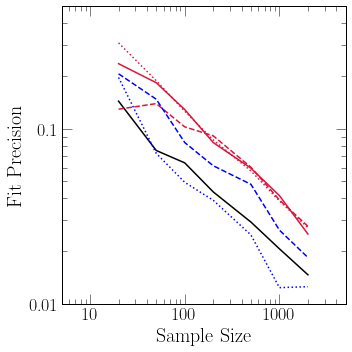

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xscale("log")
ax.set_yscale("log")
ax.xaxis.set_major_formatter(fsf("%g"))
ax.yaxis.set_major_formatter(fsf("%g"))
ax.set_xlabel("Sample Size")
# ax.set_ylabel(r"$\sigma/\theta$")
ax.set_ylabel(r"Fit Precision")
ax.set_xlim([5, 5000])
ax.set_ylim([0.01, 0.5])

samplesizes = list(rederived_samplesize.keys())
dim = len(rederived_samplesize[samplesizes[0]])
colors = ["crimson", "black", "crimson", "crimson", "blue", "blue"]
linestyles = ["-", "-", ":", "--", ":", "--"]
labels = [r"$\tau_\text{in}$", r"$\eta$", r"$\tau_\star$",
    r"$\tau_\text{tot}$", r"$y_\text{Fe}^\text{CC}$", r"$y_\text{Fe}^\text{Ia}$"]
for i in range(dim):
    yvals = []
    for s in samplesizes:
        rederived = rederived_samplesize[s][i]
        sigma = (rederived[1] + rederived[2]) / 2
        yvals.append(sigma / rederived[0])
    kwargs = {
        "c": named_colors()[colors[i]],
        "linestyle": linestyles[i],
        "label": labels[i]
    }
    ax.plot(samplesizes, yvals, **kwargs)

# kwargs = {
#     "loc": mpl_loc("upper right"),
#     "fontsize": 20
# }
# leg = ax.legend(**kwargs)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("../paper/precision_samplesize.%s" % (ext), **kwargs)
plt.show()

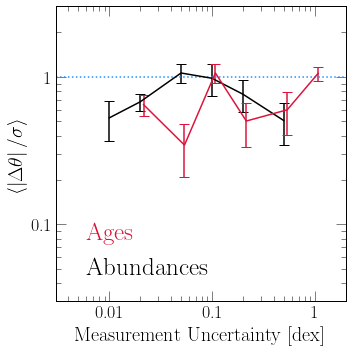

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xscale("log")
ax.set_yscale("log")
ax.xaxis.set_major_formatter(fsf("%g"))
ax.yaxis.set_major_formatter(fsf("%g"))
ax.set_xlabel("Measurement Uncertainty [dex]")
ax.set_ylabel(r"$\langle\left|\Delta\theta\right|/\sigma\rangle$")
ax.set_xlim([0.003, 2])
ax.set_ylim([0.03, 3])

yvals = []
errors = []
for samplesize in rederived_abundanceprecision.keys():
    bestfits = rederived_abundanceprecision[samplesize]
    deltas = len(true_values) * [0.]
    for i in range(len(deltas)):
        deltas[i] = abs(bestfits[i][0] - true_values[i])
        sigma = (bestfits[i][1] + bestfits[i][2]) / 2
        deltas[i] /= sigma
    yvals.append(np.mean(deltas))
    errors.append(np.std(deltas) / np.sqrt(len(deltas)))
    
xvals = list(rederived_abundanceprecision.keys())
ax.errorbar(xvals, yvals, yerr = errors, c = named_colors()["black"])

yvals = []
errors = []
for samplesize in rederived_ageprecision.keys():
    bestfits = rederived_ageprecision[samplesize]
    deltas = len(true_values) * [0.]
    for i in range(len(deltas)):
        deltas[i] = abs(bestfits[i][0] - true_values[i])
        sigma = (bestfits[i][1] + bestfits[i][2]) / 2
        deltas[i] /= sigma
    yvals.append(np.mean(deltas))
    errors.append(np.std(deltas) / np.sqrt(len(deltas)))

xvals = [_ * 1.08 for _ in list(rederived_ageprecision.keys())]
ax.errorbar(xvals, yvals, yerr = errors, c = named_colors()["crimson"])

ax.axhline(1, c = named_colors()["dodgerblue"], linestyle = ':')

ax.plot([1e-5, 1e-4], [1e-5, 1e-4], c = named_colors()["crimson"],
    label = "Ages")
ax.plot([1e-5, 1e-4], [1e-5, 1e-4], c = named_colors()["black"],
    label = "Abundances")

kwargs = {
    "loc": mpl_loc("lower left"),
    "handlelength": 0,
    "fontsize": 25
}
leg = ax.legend(**kwargs)
fancy_legend(leg, ["crimson", "black"])

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("../paper/dp_sigma_precision.%s" % (ext), **kwargs)
plt.show()

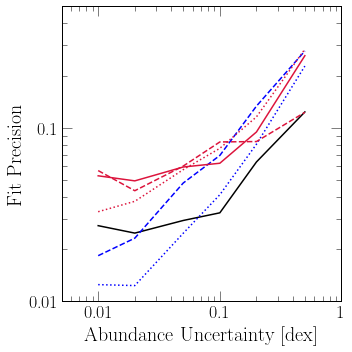

In [8]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)
ax.set_xscale("log")
ax.set_yscale("log")
ax.xaxis.set_major_formatter(fsf("%g"))
ax.yaxis.set_major_formatter(fsf("%g"))
ax.set_xlabel("Abundance Uncertainty [dex]")
# ax.set_ylabel(r"$\sigma/\theta$")
ax.set_ylabel("Fit Precision")
ax.set_xlim([0.005, 1])
ax.set_ylim([0.01, 0.5])

precisions = list(rederived_abundanceprecision.keys())
dim = len(rederived_abundanceprecision[precisions[0]])
colors = ["crimson", "black", "crimson", "crimson", "blue", "blue"]
linestyles = ["-", "-", ":", "--", ":", "--"]
labels = [r"$\tau_\text{in}$", r"$\eta$", r"$\tau_\star$",
    r"$\tau_\text{tot}$", r"$y_\text{Fe}^\text{CC}$", r"$y_\text{Fe}^\text{Ia}$"]
# for i in range(dim):
for i in [1, 4, 5, 0, 2, 3]:
    yvals = []
    for p in precisions:
        rederived = rederived_abundanceprecision[p]
        sigma = (rederived[i][1] + rederived[i][2]) / 2
        yvals.append(sigma / rederived[i][0])
    kwargs = {
        "c": named_colors()[colors[i]],
        "linestyle": linestyles[i],
        "label": labels[i]
    }
    ax.plot(precisions, yvals, **kwargs)

# kwargs = {
#     "loc": mpl_loc("upper left"),
#     "fontsize": 20,
#     "ncol": 2,
#     "columnspacing": 1,
#     "handlelength": 1.5
# }
# leg = ax.legend(**kwargs)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("../paper/precision_abundanceuncertainty.%s" % (ext), **kwargs)
plt.show()

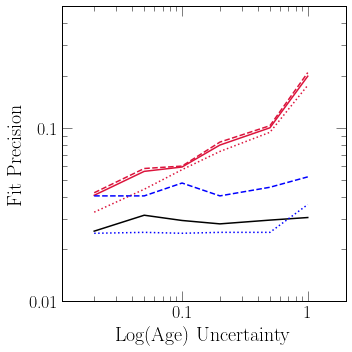

In [9]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)
ax.set_xscale("log")
ax.set_yscale("log")
ax.xaxis.set_major_formatter(fsf("%g"))
ax.yaxis.set_major_formatter(fsf("%g"))
ax.set_xlabel("Log(Age) Uncertainty")
# ax.set_ylabel(r"$\sigma/\theta$")
ax.set_ylabel("Fit Precision")
ax.set_xlim([0.011, 2])
ax.set_ylim([0.01, 0.5])

precisions = list(rederived_ageprecision.keys())
dim = len(rederived_ageprecision[precisions[0]])
colors = ["crimson", "black", "crimson", "crimson", "blue", "blue"]
linestyles = ["-", "-", ":", "--", ":", "--"]
labels = [r"$\tau_\text{in}$", r"$\eta$", r"$\tau_\star$",
    r"$\tau_\text{tot}$", r"$y_\text{Fe}^\text{CC}$", r"$y_\text{Fe}^\text{Ia}$"]
for i in range(dim):
    yvals = []
    for p in precisions:
        rederived = rederived_ageprecision[p]
        sigma = (rederived[i][1] + rederived[i][2]) / 2
        yvals.append(sigma / rederived[i][0])
    kwargs = {
        "c": named_colors()[colors[i]],
        "linestyle": linestyles[i],
        "label": labels[i]
    }
    ax.plot(precisions, yvals, **kwargs)
    
# kwargs = {
#     "loc": mpl_loc("upper left"),
#     "fontsize": 20
# }
# leg = ax.legend(**kwargs)
    
plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("../paper/precision_ageuncertainty.%s" % (ext), **kwargs)
plt.show()

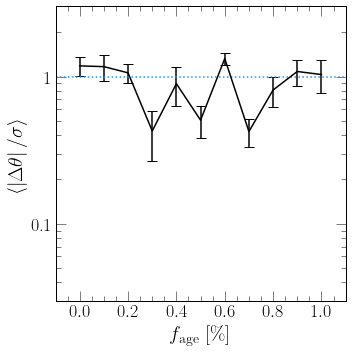

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.set_xscale("log")
ax.set_yscale("log")
# ax.xaxis.set_major_formatter(fsf("%g"))
ax.yaxis.set_major_formatter(fsf("%g"))
ax.set_xlabel(r"$f_\text{age}$ [\%]")
ax.set_ylabel(r"$\langle\left|\Delta\theta\right|/\sigma\rangle$")
ax.set_xlim([-0.1, 1.1])
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylim([0.03, 3])

yvals = []
errors = []
for samplesize in rederived_agefrac.keys():
    bestfits = rederived_agefrac[samplesize]
    deltas = len(true_values) * [0.]
    for i in range(len(deltas)):
        deltas[i] = abs(bestfits[i][0] - true_values[i])
        sigma = (bestfits[i][1] + bestfits[i][2]) / 2
        deltas[i] /= sigma
    yvals.append(np.mean(deltas))
    errors.append(np.std(deltas) / np.sqrt(len(deltas)))
    
xvals = list(rederived_agefrac.keys())
ax.errorbar(xvals, yvals, yerr = errors, c = named_colors()["black"])
ax.axhline(1, c = named_colors()["dodgerblue"], linestyle = ':')

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("../paper/dp_sigma_agefrac.%s" % (ext), **kwargs)
plt.show()

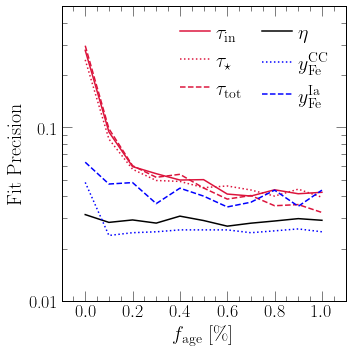

In [11]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)
# ax.set_xscale("log")
ax.set_yscale("log")
# ax.xaxis.set_major_formatter(fsf("%g"))
ax.yaxis.set_major_formatter(fsf("%g"))
ax.set_xlabel(r"$f_\text{age}$ [\%]")
# ax.set_ylabel(r"$\sigma/\theta$")
ax.set_ylabel("Fit Precision")
ax.set_xlim([-0.1, 1.1])
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylim([0.01, 0.5])

agefracs = list(rederived_agefrac.keys())
dim = len(rederived_agefrac[agefracs[0]])
colors = ["crimson", "black", "crimson", "crimson", "blue", "blue"]
linestyles = ["-", "-", ":", "--", ":", "--"]
labels = [r"$\tau_\text{in}$", r"$\eta$", r"$\tau_\star$",
    r"$\tau_\text{tot}$", r"$y_\text{Fe}^\text{CC}$", r"$y_\text{Fe}^\text{Ia}$"]
# for i in range(dim):
for i in [0, 2, 3, 1, 4, 5]:
    yvals = []
    for frac in agefracs:
        rederived = rederived_agefrac[frac]
        sigma = (rederived[i][1] + rederived[i][2]) / 2
        yvals.append(sigma / rederived[i][0])
    kwargs = {
        "c": named_colors()[colors[i]],
        "linestyle": linestyles[i],
        "label": labels[i]
    }
    ax.plot(agefracs, yvals, **kwargs)
    
# kwargs = {
#     "loc": mpl_loc("upper right"),
#     "fontsize": 20
# }
# leg = ax.legend(**kwargs)

kwargs = {
    "loc": mpl_loc("upper right"),
    "fontsize": 20,
    "ncol": 2,
    "columnspacing": 1,
    "handlelength": 1.5
}
leg = ax.legend(**kwargs)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("../paper/precision_agefrac.%s" % (ext), **kwargs)
plt.show()

In [59]:
raw = np.genfromtxt("../data/gse/gsechem.dat")
# raw = np.array(list(filter(lambda x: 10**x[-2] > 7 or np.isnan(x[-2]), raw)))
gse = vice.dataframe({})
gse["[fe/h]"] = raw[:, 0]
gse["[fe/h]_err"] = raw[:, 1]
gse["[o/fe]"] = raw[:, 2]
gse["[o/fe]_err"] = raw[:, 3]
gse["age"] = [10**_ for _ in raw[:, 4]]
gse["age_err"] = [a * b * m.log(10) for a, b in zip(gse["age"], raw[:, 5])]

raw = np.genfromtxt("../data/gse/gsechem_512k.out")
raw = np.array(list(filter(lambda _: 0.4 <= _[0] <= 1.6, raw)))
chain = vice.dataframe({})
chain["tau_in"] = [row[0] for row in raw]
chain["eta"] = [row[1] for row in raw]
chain["tau_star"] = [row[2] for row in raw]
chain["tau_tot"] = [row[3] for row in raw]
chain["y_fe_cc"] = [row[4] for row in raw]
chain["y_fe_ia"] = [row[5] for row in raw]
chain["logp"] = [row[6] for row in raw]
minlogp = min(chain["logp"])
chain["logp"] = [_ - minlogp for _ in chain["logp"]]

# diff = min(chain["logp"]) + 400
# chain["logp"] = [_ - diff for _ in chain["logp"]]
# chain = chain.filter("logp", ">=", 0)
print(len(chain["logp"]))
print(min(chain["logp"]))
print(max(chain["logp"]))

477614
0.0
206.735


In [24]:
class gaussian:
    
    def __init__(self, mean = 0, width = 1):
        self.mean = mean
        self.width = width
        
    def __call__(self, x):
        return 1 / (self.width * np.sqrt(2 * np.pi)) * np.exp(
            -(x - self.mean)**2 / (2 * self.width**2)
        )

class lognormal:
    
    def __init__(self, mean = 0, width = 1):
        self.mean = mean
        self.width = width
        
    def __call__(self, x):
        return 1 / (x * self.width * np.sqrt(2 * np.pi)) * np.exp(
            -(np.log10(x) - np.log10(self.mean))**2 / (2 * self.width**2)
        )
    
def convolve(dist, bins, sigma, which = gaussian):
    new_dist = len(dist) * [0.]
    g = which(width = sigma)
    for i in range(len(new_dist)):
        g.mean = (bins[i] + bins[i + 1]) / 2
        for j in range(len(dist)):
            x = (bins[j] + bins[j + 1]) / 2
            new_dist[i] += dist[j] * g(x)
    norm = 0
    for i in range(len(dist)): norm += new_dist[i] * (bins[i + 1] - bins[i])
    new_dist = [_ / norm for _ in new_dist]
    return new_dist

/var/home/johnson.7419.local/VICE/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: func
  warnings.warn("""\


199


/home/johnson.7419/tmp/ipykernel_19375/603970600.py:171: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


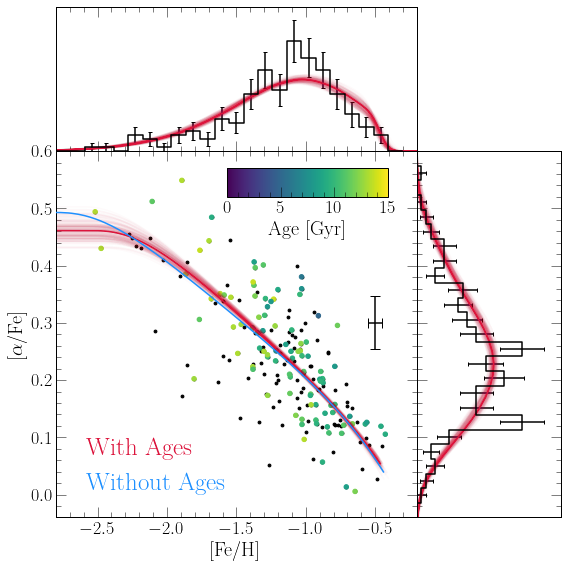

In [77]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111)
ax.set_xlabel("[Fe/H]")
ax.set_ylabel(r"[$\alpha$/Fe]")
ax.set_xlim([-2.8, -0.2])
ax.set_ylim([-0.04, 0.6])

med_feh_err = np.median(gse["[fe/h]_err"])
med_ofe_err = np.median(gse["[o/fe]_err"])

kwargs = {
    "c": named_colors()["black"],
    "s": 8
}
ax.scatter(gse["[fe/h]"], gse["[o/fe]"], **kwargs)
kwargs["s"] = 20
kwargs["c"] = gse["age"]
kwargs["cmap"] = "viridis"
kwargs["vmin"] = 0
kwargs["vmax"] = 15
sc = ax.scatter(gse["[fe/h]"], gse["[o/fe]"], **kwargs)
cbar_ax = fig.add_axes([0.4, 0.65, 0.28, 0.05])
cbar = plt.colorbar(sc, cax = cbar_ax, pad = 0, orientation = "horizontal")
cbar.set_label("Age [Gyr]", labelpad = 3)
cbar.set_ticks(range(0, 16, 5))
ax.errorbar(-0.5, 0.3, xerr = med_feh_err, yerr = med_ofe_err,
    c = named_colors()["black"])

top = fig.add_axes([0.1, 0.9, 0.8, 0.1])
right = fig.add_axes([0.9, 0.1, 0.1, 0.8])
plt.setp(top.get_xticklabels(), visible = False)
plt.setp(top.get_yticklabels(), visible = False)
plt.setp(right.get_xticklabels(), visible = False)
plt.setp(right.get_yticklabels(), visible = False)
top.set_xlim(ax.get_xlim())
top.set_ylim([0, 1.8])
top.tick_params(axis = "y", which = "both", left = False, right = False)
right.set_xlim([0, 6.5])
right.set_ylim(ax.get_ylim())
right.tick_params(axis = "x", which = "both", bottom = False, top = False)

kwargs = {
    "bins": 25,
    "range": ax.get_xlim()
}
feh_counts, _ = np.histogram(gse["[fe/h]"], density = False, **kwargs)
feh_dist, feh_bins = np.histogram(gse["[fe/h]"], density = True, **kwargs)
idx = feh_counts.tolist().index(max(feh_counts))
norm = feh_counts[idx] / feh_dist[idx]
errors = [np.sqrt(_) / norm for _ in feh_counts]
top.step(feh_bins[:-1], feh_dist, where = "post", c = named_colors()["black"], zorder = 100)
xvals = [(a + b) / 2 for a, b in zip(feh_bins[:-1], feh_bins[1:])]
top.errorbar(xvals, feh_dist, yerr = errors, c = named_colors()["black"],
    capsize = 2, linestyle = "None")

kwargs["range"] = ax.get_ylim()
afe_counts, _ = np.histogram(gse["[o/fe]"], density = False, **kwargs)
afe_dist, afe_bins = np.histogram(gse["[o/fe]"], density = True, **kwargs)
idx = afe_counts.tolist().index(max(afe_counts))
norm = afe_counts[idx] / afe_dist[idx]
errors = [np.sqrt(_) / norm for _ in afe_counts]
right.step(afe_dist, afe_bins[:-1], where = "pre", c = named_colors()["black"], zorder = 100)
xvals = [(a + b) / 2 for a, b in zip(afe_bins[:-1], afe_bins[1:])]
right.errorbar(afe_dist, xvals, xerr = errors, c = named_colors()["black"],
    capsize = 2, linestyle = "None")

bf_duration = 5.40
with vice.singlezone(name = "./gse") as sz:
    sz.elements = ["fe", "o"]
    sz.func = exponential(prefactor = 1000)
    sz.func.timescale = 1.01
    sz.mode = "ifr"
    sz.dt = bf_duration / 1000
    sz.Mg0 = 0
#     sz.nthreads = 2
    sz.eta = 8.84
    sz.tau_star = 16.08
    sz.bins = np.linspace(-3, 1, 201)
    vice.yields.ccsne.settings['o'] = 0.01
    vice.yields.sneia.settings['o'] = 0
    vice.yields.ccsne.settings['fe'] = 0.78 / 1000
    vice.yields.sneia.settings['fe'] = 1.23 / 1000
    bfout = sz.run(np.linspace(0, bf_duration, 1001), overwrite = True, capture = True)

kwargs = {
    "c": named_colors()["crimson"],
    "label": "With Ages"
}
ax.plot(bfout.history["[fe/h]"], bfout.history["[o/fe]"], **kwargs)

bins = bfout.mdf["bin_edge_left"] + [bfout.mdf["bin_edge_right"][-1]]
xvals = [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])]
feh_dist = convolve(bfout.mdf["dn/d[fe/h]"], bins, med_feh_err)
ofe_dist = convolve(bfout.mdf["dn/d[o/fe]"], bins, med_ofe_err)
top.plot(xvals, feh_dist, **kwargs)
right.plot(ofe_dist, xvals, **kwargs)

noages_duration = 10.73
with vice.singlezone(name = "./gse_noages") as sz:
    sz.elements = ["fe", "o"]
    sz.func = exponential(prefactor = 1000)
    sz.func.timescale = 2.18
    sz.mode = "ifr"
    sz.dt = noages_duration / 1000
    sz.Mg0 = 0
#     sz.nthreads = 2
    sz.eta = 9.56
    sz.tau_star = 26.60
    sz.bins = np.linspace(-3, 1, 201)
    vice.yields.ccsne.settings['o'] = 0.01
    vice.yields.sneia.settings['o'] = 0
    vice.yields.ccsne.settings['fe'] = 7.25e-4
    vice.yields.sneia.settings['fe'] = 1.06e-3
    noages_out = sz.run(np.linspace(0, noages_duration, 1001), overwrite = True, capture = True)
    
kwargs = {
    "c": named_colors()["dodgerblue"],
    "label": "Without Ages",
    "zorder": 1000
}
ax.plot(noages_out.history["[fe/h]"], noages_out.history["[o/fe]"], **kwargs)

random.seed(a = 0)
n_subs = 200
prob = [m.exp(_) for _ in chain["logp"]]
norm = sum(prob)
prob = [_ / norm for _ in prob]
indeces = np.random.choice(list(range(len(prob))), p = prob, size = n_subs)
kwargs = {
    "c": named_colors()["crimson"]
}

with vice.singlezone() as sz:
    for i in range(n_subs):
        sz.name = "gse_subsamples/gse%d" % (i)
        sz.elements = ["fe", "o"]
        sz.func = exponential(prefactor = 1000, timescale = chain["tau_in"][indeces[i]])
        sz.mode = "ifr"
        sz.Mg0 = 0
#         sz.nthreads = 2
        sz.tau_star = chain["tau_star"][indeces[i]]
        sz.eta = chain["eta"][indeces[i]]
        sz.dt = chain["tau_tot"][indeces[i]] / 500
        sz.bins = np.linspace(-3, 1, 201)
        vice.yields.ccsne.settings['fe'] = chain["y_fe_cc"][indeces[i]]
        vice.yields.sneia.settings['fe'] = chain["y_fe_ia"][indeces[i]]
        out = sz.run(np.linspace(0, chain["tau_tot"][indeces[i]], 501),
            overwrite = True, capture = True)

        kwargs["alpha"] = 0.02
        ax.plot(out.history["[fe/h]"], out.history["[o/fe]"], **kwargs)

        bins = out.mdf["bin_edge_left"] + [out.mdf["bin_edge_right"][-1]]
        xvals = [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])]
        feh_dist = convolve(out.mdf["dn/d[fe/h]"], bins, med_feh_err)
        ofe_dist = convolve(out.mdf["dn/d[o/fe]"], bins, med_ofe_err)
        top.plot(xvals, feh_dist, **kwargs)
        right.plot(ofe_dist, xvals, **kwargs)

        sys.stdout.write("\r%d" % (i))
sys.stdout.write("\n")

kwargs = {
    "loc": mpl_loc("lower left"),
    "handlelength": 0,
    "fontsize": 25
}
leg = ax.legend(**kwargs)
fancy_legend(leg, ["crimson", "dodgerblue"])

plt.tight_layout()
plt.subplots_adjust(right = 0.73, top = 0.73)
top.set_position([
    ax.get_position().x0,
    ax.get_position().y1,
    ax.get_position().x1 - ax.get_position().x0,
    0.25
])
right.set_position([
    ax.get_position().x1,
    ax.get_position().y0,
    0.25,
    ax.get_position().y1 - ax.get_position().y0
])
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("../paper/gsefit_afe_feh.%s" % (ext), **kwargs)
plt.show()

In [57]:
cosmological_age = 13.2
# sub = gse.filter("age", ">=", 7)
sub = vice.dataframe(gse.todict())
print(len(sub["age"]))
quantities = list(filter(lambda _: not _.endswith("_err"), sub.keys()))
sub["age"] = [m.log10(_) for _ in sub["age"]]
sub["age_err"] = [0.05 if not m.isnan(_) else float("nan") for _ in sub["age"]]
print(sub["age_err"])
sample = np.array([sub[key] for key in quantities]).T
errors = np.array([sub["%s_err" % (key)] for key in quantities]).T
# model = len(bfout.history["time"]) * [None]
model = len(noages_out.history["time"]) * [None]
for i in range(len(model)):
    model[i] = len(quantities) * [0.]
    for j in range(len(quantities)):
        if quantities[j] == "age":
#             model[i][j] = m.log10(bfout.history["lookback"][i] + cosmological_age - bf_duration)
            model[i][j] = m.log10(noages_out.history["lookback"][i] + cosmological_age - noages_duration)
        else:
#             model[i][j] = bfout.history[quantities[j]][i]
            model[i][j] = noages_out.history[quantities[j]][i]
model = model[1:] # chop off the -inf [Fe/H] predicted at t = 0
# weights = bfout.history["sfr"][1:]
weights = noages_out.history["sfr"][1:]
N = 0
for i in range(len(sample)):
    for j in range(len(sample[i])):
        if not m.isnan(sample[i][j]): N += 1
chisq = chisquared(sample, errors, model, weights)
print(chisq / (N - 6))

187
[nan, 0.05, 0.05, 0.05, 0.05, nan, 0.05, nan, nan, 0.05, nan, nan, 0.05, nan, nan, nan, 0.05, nan, 0.05, nan, nan, 0.05, 0.05, nan, 0.05, nan, nan, nan, nan, nan, nan, nan, nan, 0.05, nan, 0.05, 0.05, 0.05, nan, 0.05, nan, 0.05, nan, 0.05, nan, 0.05, nan, nan, nan, 0.05, 0.05, nan, 0.05, 0.05, 0.05, nan, nan, nan, nan, nan, 0.05, 0.05, nan, nan, nan, nan, nan, 0.05, nan, 0.05, nan, nan, 0.05, 0.05, nan, 0.05, 0.05, 0.05, 0.05, 0.05, nan, 0.05, 0.05, nan, nan, 0.05, nan, 0.05, 0.05, nan, nan, nan, nan, nan, 0.05, nan, 0.05, nan, nan, nan, 0.05, 0.05, nan, 0.05, 0.05, nan, nan, 0.05, 0.05, nan, nan, 0.05, 0.05, 0.05, nan, nan, 0.05, 0.05, nan, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, nan, nan, 0.05, 0.05, nan, 0.05, nan, nan, 0.05, 0.05, 0.05, nan, nan, 0.05, 0.05, 0.05, 0.05, nan, 0.05, 0.05, nan, nan, nan, nan, nan, nan, 0.05, 0.05, nan, nan, 0.05, 0.05, 0.05, 0.05, 0.05, nan, nan, nan, nan, 0.05, 0.05, nan, 0.05, nan, nan, nan, 0.05, 0.05, 0.05, 0.05, nan, 0.05, 0.05, nan, nan, nan, 0.

199


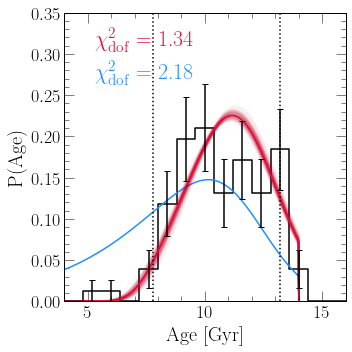

In [78]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)
ax.set_xlabel("Age [Gyr]")
ax.set_ylabel("P(Age)")
ax.set_xlim([4, 16])
ax.set_xticks([5, 10, 15])
ax.set_ylim([0, 0.35])

kwargs = {
    "bins": 25,
    "range": [0, 20]
}
age_counts, _ = np.histogram(gse["age"], density = False, **kwargs)
age_dist, age_bins = np.histogram(gse["age"], density = True, **kwargs)
idx = age_counts.tolist().index(max(age_counts))
norm = age_counts[idx] / age_dist[idx]
errors = [np.sqrt(_) / norm for _ in age_counts]
ax.step(age_bins[:-1], age_dist, where = "post", c = named_colors()["black"])
xvals = [(a + b) / 2 for a, b in zip(age_bins[:-1], age_bins[1:])]
ax.errorbar(xvals, age_dist, yerr = errors, c = named_colors()["black"], linestyle = "None", zorder = 100,
    capsize = 3)
    
def plotsub(name, **kwargs):
    out = vice.output(name)
    diff = 13.2 - out.history["time"][-1]
    lookback = [_ + diff for _ in out.history["lookback"]][::-1]
    dt = out.history["time"][1] - out.history["time"][0]
    ages = np.arange(0, 14, dt).tolist()
    agedist = (len(ages) - 1) * [0.]
    for i in range(len(agedist)):
        for j in range(len(lookback)):
            if abs(ages[i] - lookback[j]) < dt / 2:
                agedist[i] = out.history["sfr"][-j]
                break
            else: continue
    norm = 0
    for i in range(len(agedist)): norm += agedist[i] * (ages[i + 1] - ages[i])
    agedist = [_ / norm for _ in agedist]
    agedist = convolve(agedist, ages, 0.05, which = lognormal)
    ages.append(14)
    agedist.append(0)
    ax.plot(ages[1:], agedist, **kwargs)

plotsub("gse", c = named_colors()["crimson"])
plotsub("gse_noages", c = named_colors()["dodgerblue"])
for i in range(200):
    plotsub("gse_subsamples/gse%d" % (i), c = named_colors()["crimson"], alpha = 0.02)
    sys.stdout.write("\r%d" % (i))
sys.stdout.write("\n")
ax.axvline(13.2, c = named_colors()["black"], linestyle = ':')
ax.axvline(13.2 - 5.4, c = named_colors()["black"], linestyle = ':')

ax.text(5.3, 0.31, r"$\chi_\text{dof}^2$ = 1.34", fontsize = 22, c = named_colors()["crimson"])
ax.text(5.3, 0.27, r"$\chi_\text{dof}^2$ = 2.18", fontsize = 22, c = named_colors()["dodgerblue"])

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("../paper/gsefit_agedist.%s" % (ext), **kwargs)
plt.show()

199


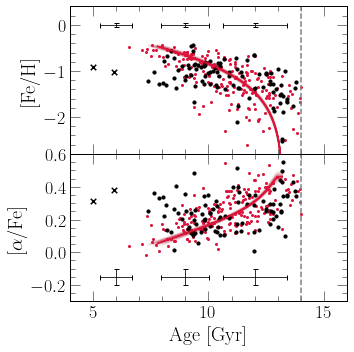

In [60]:
fig = plt.figure(figsize = (5, 5))
top = fig.add_subplot(211)
bottom = fig.add_subplot(212)
for ax in [top, bottom]:
    ax.set_xlim([4, 16])
    ax.axvline(14, c = named_colors()["grey"], linestyle = "--")
    ax.set_xticks([5, 10, 15])
plt.setp(top.get_xticklabels(which = "both"), visible = False)
top.set_ylim([-2.8, 0.4])
bottom.set_ylim([-0.3, 0.6])
bottom.set_yticks([-0.2, 0, 0.2, 0.4, 0.6])
bottom.set_xlabel("Age [Gyr]")
bottom.set_ylabel(r"[$\alpha$/Fe]")
top.set_ylabel("[Fe/H]")
random.seed(a = 2)

med_feh_err = np.median(gse["[fe/h]_err"])
med_afe_err = np.median(gse["[o/fe]_err"])

sub = gse.filter("age", ">=", 7)
kwargs = {
    "c": named_colors()["black"],
    "s": 10,
    "zorder": 50
}
top.scatter(sub["age"], sub["[fe/h]"], **kwargs)
bottom.scatter(sub["age"], sub["[o/fe]"], **kwargs)

sub = gse.filter("age", "<=", 7)
kwargs["marker"] = markers()["x"]
kwargs["s"] = 30
top.scatter(sub["age"], sub["[fe/h]"], **kwargs)
bottom.scatter(sub["age"], sub["[o/fe]"], **kwargs)

# ageval = 6
# age_err = [[ageval - 10**(m.log10(ageval - 0.05 * ageval * m.log(10)))],
#     [10**(m.log10(ageval + 0.05 * ageval * m.log(10))) - ageval]]
# bottom.errorbar(ageval, 0.0, xerr = age_err, yerr = 0.05, c = named_colors()["black"])
# top.errorbar(ageval, -2, xerr = age_err, yerr = 0.05, c = named_colors()["black"])

agevals = [6, 9, 12]
for age in agevals:
    age_err = [[age - 10**(m.log10(age - 0.05 * age * m.log(10)))],
        [10**(m.log10(age + 0.05 * age * m.log(10))) - age]]
    kwargs = {
        "xerr": age_err,
        "c": named_colors()["black"],
        "linewidth": 0.8,
        "capsize": 2.5
    }
    bottom.errorbar(age, -0.15, yerr = med_afe_err, **kwargs)
    top.errorbar(age, 0, yerr = med_feh_err, **kwargs)
    
# with vice.output("./gse_noages") as noages:
#     diff = 13.2 - noages.history["time"][-1]
#     xvals = [_ + diff for _ in noages.history["lookback"]]
#     kwargs = {
#         "c": named_colors()["dodgerblue"],
#         "zorder": 1000
#     }
#     top.plot(xvals, noages.history["[fe/h]"], **kwargs)
#     bottom.plot(xvals, noages.history["[o/fe]"], **kwargs)    

with vice.output("./gse") as bfout:
    diff = 13.2 - bfout.history["time"][-1]
    xvals = [_ + diff for _ in bfout.history["lookback"]]
    kwargs = {
        "c": named_colors()["crimson"],
        "zorder": 100
    }
    top.plot(xvals, bfout.history["[fe/h]"], **kwargs)
    bottom.plot(xvals, bfout.history["[o/fe]"], **kwargs)
#     xvals_low = [_ - _ * np.log(10) * 0.05 for _ in xvals]
#     xvals_high = [_ + _ * np.log(10) * 0.05 for _ in xvals]
#     kwargs["color"] = kwargs["c"]
#     del kwargs["c"]
#     kwargs["alpha"] = 0.3
#     top.fill_betweenx(bfout.history["[fe/h]"], xvals_low, xvals_high, **kwargs)
#     bottom.fill_betweenx(bfout.history["[o/fe]"], xvals_low, xvals_high, **kwargs)

#     totsfr = sum(true.history["sfr"])
#     sfrfrac = [_ / totsfr for _ in true.history["sfr"]]
#     indeces = np.random.choice(list(range(len(sfrfrac))), p = sfrfrac, size = int(1e4))
#     resampled = [diff + true.history["lookback"][indeces[_]] for _ in range(len(indeces))]
#     resampled = [10**(m.log10(_) + np.random.normal(scale = 0.1)) for _ in resampled]
#     dist, bins = np.histogram(resampled, bins = 100, range = [0, 30], density = True)
#     xvals = [(a + b) / 2 for a, b in zip(bins[1:], bins[:-1])]

def plotsampled():
    with vice.output("./gse") as bfout:
        totsfr = sum(bfout.history["sfr"])
        sfrfrac = [_ / totsfr for _ in bfout.history["sfr"]]
        indeces = np.random.choice(list(range(len(sfrfrac))), p = sfrfrac, size = len(gse["[fe/h]"]))
        ages = [diff + bfout.history["lookback"][indeces[_]] for _ in range(len(indeces))]
        feh = [bfout.history["[fe/h]"][indeces[_]] for _ in range(len(indeces))]
        afe = [bfout.history["[o/fe]"][indeces[_]] for _ in range(len(indeces))]
        for i in range(len(indeces)):
            while True:
                test = 10**(np.log10(ages[i]) + np.random.normal(scale = 0.05))
                if test <= 14: break
            ages[i] = test
            feh[i] += np.random.normal(scale = med_feh_err)
            afe[i] += np.random.normal(scale = med_afe_err)
        kwargs = {
            "c": named_colors()["crimson"],
            "s": 4,
            "zorder": -100,
        }
        top.scatter(ages, feh, **kwargs)
        bottom.scatter(ages, afe, **kwargs)
        
plotsampled()

def plotsub(sub):
    out = vice.output("./gse_subsamples/gse%d" % (sub))
    kwargs = {
        "c": named_colors()["crimson"],
        "alpha": 0.01,
        "zorder": 100
    }
    xvals = [_ + 13.2 - out.history["time"][-1] for _ in out.history["lookback"]]
    top.plot(xvals, out.history["[fe/h]"], **kwargs)
    bottom.plot(xvals, out.history["[o/fe]"], **kwargs)
    
n_subs = 200
for i in range(n_subs):
    plotsub(i)
    sys.stdout.write("\r%d" % (i))
sys.stdout.write("\n")

# random.seed(a = 0)
# n_subs = 200
# prob = [m.exp(_) for _ in chain["logp"]]
# norm = sum(prob)
# prob = [_ / norm for _ in prob]
# indeces = np.random.choice(list(range(len(prob))), p = prob, size = n_subs)
# kwargs = {
#     "c": named_colors()["crimson"]
# }

# with vice.singlezone(name = "sampled") as sz:
#     for i in range(n_subs):
#         sz.elements = ["fe", "o"]
#         sz.func = exponential(timescale = chain["tau_in"][indeces[i]])
#         sz.func.timescale = chain["tau_in"][indeces[i]]
#         sz.mode = "ifr"
#         sz.Mg0 = 0
#         sz.nthreads = 2
#         sz.tau_star = chain["tau_star"][indeces[i]]
#         sz.eta = chain["eta"][indeces[i]]
#         sz.dt = chain["tau_tot"][indeces[i]] / 500
#         vice.yields.ccsne.settings['fe'] = chain["y_fe_cc"][indeces[i]]
#         vice.yields.sneia.settings['fe'] = chain["y_fe_ia"][indeces[i]]
#         out = sz.run(np.linspace(0, chain["tau_tot"][indeces[i]], 501),
#             overwrite = True, capture = True)

#         kwargs["alpha"] = 0.01
#         diff = 13.2 - out.history["time"][-1]
#         xvals = [_ + diff for _ in out.history["lookback"]]
#         top.plot(xvals, out.history["[fe/h]"], **kwargs)
#         bottom.plot(xvals, out.history["[o/fe]"], **kwargs)

#         sys.stdout.write("\r%d" % (i))
# sys.stdout.write("\n")

plt.tight_layout()
plt.subplots_adjust(hspace = 0, left = 0.2)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("../paper/gsefit_amr.%s" % (ext), **kwargs)
plt.show()

199


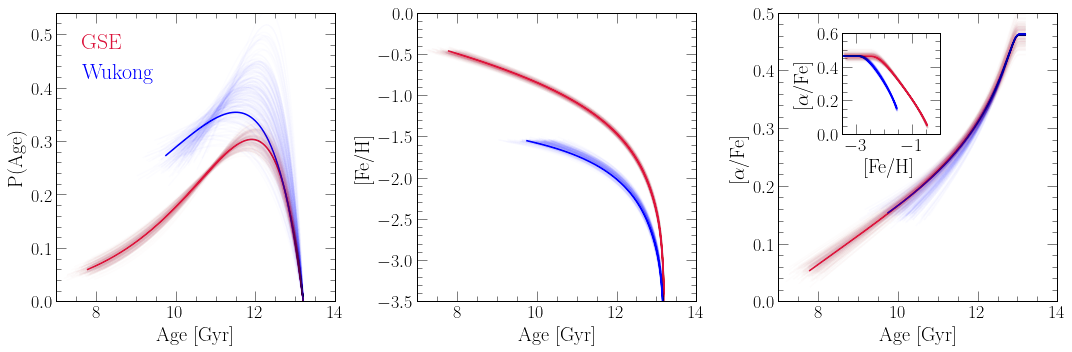

In [40]:
fig = plt.figure(figsize = (15, 5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_xlabel("Age [Gyr]")
ax1.set_ylabel("P(Age)")
ax1.set_xlim([7, 14])
ax1.set_ylim([0, 0.54])

ax2.set_xlabel("Age [Gyr]")
ax2.set_ylabel("[Fe/H]")
ax2.set_xlim([7, 14])
ax2.set_ylim([-3.5, 0])
# ax2.set_yticks([-3, -2, -1])

ax3.set_xlabel("Age [Gyr]")
ax3.set_ylabel(r"[$\alpha$/Fe]")
ax3.set_xlim([7, 14])
ax3.set_ylim([0, 0.5])

inset = ax3.inset_axes([0.23, 0.58, 0.35, 0.35])
inset.set_xlabel("[Fe/H]")
inset.set_ylabel(r"[$\alpha$/Fe]")
inset.set_xlim([-3.5, 0])
inset.set_ylim([0, 0.6])
inset.set_xticks([-3, -1])
inset.set_yticks([0, 0.2, 0.4, 0.6])

# with vice.output(name = "bestfit") as gsebf:
#     kwargs = {
#         "c": named_colors()["crimson"],
#         "label": "GSE"
#     }
#     diff = 13.2 - gsebf.history["time"][-1]
#     ages = [_ + diff for _ in gsebf.history["lookback"]]
#     totsfr = sum(gsebf.history["sfr"])
#     norm = totsfr * (gsebf.history["time"][1] - gsebf.history["time"][0])
#     yvals = [_ / norm for _ in gsebf.history["sfr"]]
#     ax1.plot(ages, yvals, **kwargs)
#     ax2.plot(ages, gsebf.history["[fe/h]"], **kwargs)
#     ax3.plot(ages, gsebf.history["[o/fe]"], **kwargs)

# with vice.output(name = "wukong") as wukong:
#     kwargs = {
#         "c": named_colors()["blue"],
#         "label": "Wukong"
#     }
#     diff = 13.2 - wukong.history["time"][-1]
#     ages = [_ + diff for _ in wukong.history["lookback"]]
#     totsfr = sum(wukong.history["sfr"])
#     norm = totsfr * (wukong.history["time"][1] - wukong.history["time"][0])
#     yvals = [_ / norm for _ in wukong.history["sfr"]]
#     ax1.plot(ages, yvals, **kwargs)
#     ax2.plot(ages, wukong.history["[fe/h]"], **kwargs)
#     ax3.plot(ages, wukong.history["[o/fe]"], **kwargs)

def plotsub(name, **kwargs):
    with vice.output(name) as out:
        diff = 13.2 - out.history["time"][-1]
        ages = [_ + diff for _ in out.history["lookback"]]
        totsfr = sum(out.history["sfr"])
        norm = totsfr * (out.history["time"][1] - out.history["time"][0])
        yvals = [_ / norm for _ in out.history["sfr"]]
        ax1.plot(ages, yvals, **kwargs)
        ax2.plot(ages, out.history["[fe/h]"], **kwargs)
        ax3.plot(ages, out.history["[o/fe]"], **kwargs)
        inset.plot(out.history["[fe/h]"], out.history["[o/fe]"], **kwargs)
        
plotsub("bestfit", **{"c": named_colors()["crimson"], "label": "GSE"})
plotsub("wukong", **{"c": named_colors()["blue"], "label": "Wukong"})
for i in range(200):
    plotsub("./gse_subsamples/gse%d" % (i), **{"c": named_colors()["crimson"], "alpha": 0.01})
    plotsub("./wukong_subsamples/wukong%d" % (i), **{"c": named_colors()["blue"], "alpha": 0.01})
    sys.stdout.write("\r%d" % (i))
sys.stdout.write("\n")

kwargs = {
    "loc": mpl_loc("upper left"),
    "handlelength": 0,
    "fontsize": 22
}
leg = ax1.legend(**kwargs)
fancy_legend(leg, ["crimson", "blue"])

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("../paper/gse_wukong_comparison.%s" % (ext), **kwargs)
plt.show()

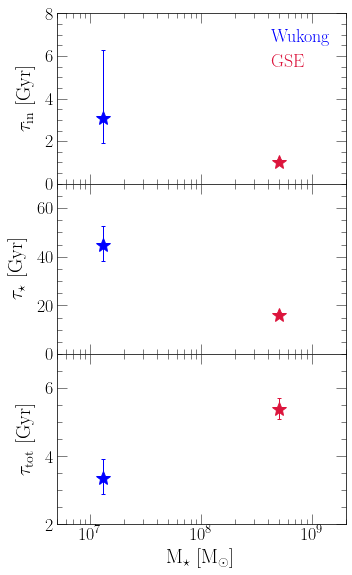

In [9]:
fig = plt.figure(figsize = (5, 8))
axes = []
ylabels = [
    r"$\tau_\text{in}$ [Gyr]", 
    r"$\tau_\star$ [Gyr]",
    r"$\tau_\text{tot}$ [Gyr]"
]
ylim = [
    [0, 8],
    [0, 70],
    [2, 7]
]
for i in range(3):
    kwargs = {}
    if i: kwargs["sharex"] = axes[0]
    axes.append(fig.add_subplot(311 + i, **kwargs))
    if i == 2: axes[i].set_xlabel(r"M$_\star$ [M$_\odot$]")
    axes[i].set_ylabel(ylabels[i], labelpad = 10)
    axes[i].set_xlim([5e6, 2e9])
    axes[i].set_ylim(ylim[i])
    axes[i].set_xscale("log")
mstar_gse = 5.0e8
mstar_wukong = 1.3e7

def plot_fit(params, mstar, **kwargs):
    keys = ["tau_in", "tau_star", "tau_tot"]
    for i in range(len(axes)):
        axes[i].errorbar(mstar, params[keys[i]][0],
            yerr = [[params[keys[i]][2]], [params[keys[i]][1]]], **kwargs)

gse_fiducial = {
    "tau_in": [1.01, 0.13, 0.13],
    "eta": [8.84, 0.83, 0.89],
    "tau_star": [16.08, 1.33, 1.26],
    "tau_tot": [5.40, 0.32, 0.31],
    "yfecc": [7.78, 0.37, 0.38],
    "yfeia": [1.23, 0.11, 0.10]
}

gse_noages = {
    "tau_in": [2.18, 0.43, 0.56],
    "eta": [9.56, 0.72, 0.77],
    "tau_star": [26.60, 4.83, 6.11],
    "tau_tot": [10.73, 1.76, 2.69],
    "yfecc": [7.25, 0.55, 0.57],
    "yfeia": [1.06, 0.10, 0.09]
}

wukong_fiducial = {
    "tau_in": [3.08, 3.19, 1.16],
    "eta": [47.99, 4.76, 4.98],
    "tau_star": [44.97, 7.85, 6.77],
    "tau_tot": [3.36, 0.55, 0.47],
    "yfecc": 3 * [float("nan")],
    "yfeia": 3 * [float("nan")]
}

wukong_withyields = {
    "tau_in": [14.80, 22.19, 11.10],
    "eta": [18.26, 15.63, 12.59],
    "tau_star": [43.98, 24.85, 12.48],
    "tau_tot": [2.33, 1.92, 0.78],
    "yfecc": [6.17, 0.55, 0.70],
    "yfeia": [2.42, 0.88, 0.65]
}

kwargs = {
    "linewidth": 1,
    "capsize": 2,
    "marker": markers()["star"],
    "markersize": 15
}
plot_fit(wukong_fiducial, mstar_wukong, c = named_colors()["blue"], **kwargs)
plot_fit(gse_fiducial, mstar_gse, c = named_colors()["crimson"], **kwargs)
# plot_fit(wukong_withyields, mstar_wukong, c = named_colors()["blue"], alpha = 0.4, **kwargs)
# plot_fit(gse_noages, mstar_gse, c = named_colors()["crimson"], alpha = 0.4, **kwargs)

line1, = axes[0].plot([1, 10], [1, 10], c = named_colors()["blue"], label = "Wukong")
line2, = axes[0].plot([1, 10], [1, 10], c = named_colors()["crimson"], label = "GSE")
kwargs = {
    "loc": mpl_loc("upper right"),
    "handlelength": 0
}
leg = axes[0].legend(**kwargs)
fancy_legend(leg, ["blue", "crimson"])

plt.tight_layout()
plt.subplots_adjust(hspace = 0)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("../paper/gse_wukong_timescales.%s" % (ext), **kwargs)
plt.show()

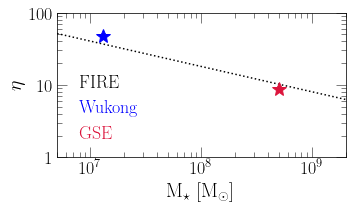

In [39]:
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(111)
ax.set_xlabel(r"M$_\star$ [M$_\odot$]")
ax.set_ylabel(r"$\eta$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim([5e6, 2e9])
ax.set_ylim([1, 100])
ax.yaxis.set_major_formatter(fsf("%g"))

kwargs = {
    "linewidth": 1,
    "capsize": 2,
    "marker": markers()["star"],
    "markersize": 15
}
ax.errorbar(mstar_wukong, wukong_fiducial["eta"][0], c = named_colors()["blue"],
    yerr = [[wukong_fiducial["eta"][2]], [wukong_fiducial["eta"][1]]], **kwargs)
ax.errorbar(mstar_gse, gse_fiducial["eta"][0], c = named_colors()["crimson"],
    yerr = [[gse_fiducial["eta"][2]], [gse_fiducial["eta"][1]]], **kwargs)

def muratov2015eta(mstar):
    return 3.6 * (mstar / 1e10)**(-0.35)

xvals = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
yvals = [muratov2015eta(_) for _ in xvals]
ax.plot(xvals, yvals, linestyle = ':', c = named_colors()["black"], label = "FIRE")

line1, = ax.plot([1, 10], [1, 10], c = named_colors()["blue"], label = "Wukong")
line2, = ax.plot([1, 10], [1, 10], c = named_colors()["crimson"], label = "GSE")
kwargs = {
    "loc": mpl_loc("lower left"),
    "handlelength": 0
}
leg = ax.legend(**kwargs)
fancy_legend(leg, ["black", "blue", "crimson"])

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("../paper/gse_wukong_eta.%s" % (ext), **kwargs)
plt.show()

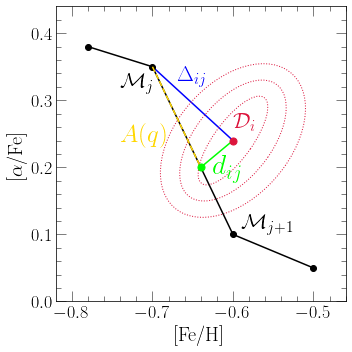

In [7]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)
ax.set_xlabel("[Fe/H]")
ax.set_ylabel(r"[$\alpha$/Fe]")
ax.set_xlim([-0.82, -0.46])
ax.set_ylim([0, 0.44])

# def plot_track():
#     vice.yields.ccsne.settings['o'] = 0.01
#     vice.yields.sneia.settings['o'] = 0
#     vice.yields.ccsne.settings['fe'] = 0.0008
#     vice.yields.sneia.settings['fe'] = 0.0011
#     with vice.singlezone(name = "tmp") as sz:
#         sz.func = exponential(prefactor = 1000)
#         sz.func.timescale = 2
#         sz.mode = "ifr"
#         sz.Mg0 = 0
#         sz.eta = 10
#         sz.tau_star = 15
#         out = sz.run(np.linspace(0, 10, 1001), overwrite = True, capture = True)
#         ax.plot(out.history["[fe/h]"], out.history["[o/fe]"], c = named_colors()["black"], linestyle = ':')

# plot_track()

x = [-0.78, -0.7, -0.6, -0.5]
y = [0.38, 0.35, 0.1, 0.05]
ax.plot(x, y, c = named_colors()["black"])
ax.scatter(x, y, c = named_colors()["black"])
ax.text(x[1] - 0.04, y[1] - 0.03, r"$\mathcal{M}_j$", fontsize = 22)
ax.text(x[2] + 0.01, y[2] + 0.01, r"$\mathcal{M}_{j + 1}$", fontsize = 22)
datum = [-0.6, 0.24]
ax.scatter(datum[0], datum[1], c = named_colors()["crimson"], s = 50, zorder = 100)
ax.text(datum[0], datum[1] + 0.02, r"$\mathcal{D}_i$", color = named_colors()["crimson"], fontsize = 22)
kwargs = {
    "angle": 60,
    "facecolor": "none",
    "edgecolor": named_colors()["crimson"],
    "linestyle": ":"
}
for i in range(3):
    ellipse = Ellipse(datum, 0.15 + 0.05 * i, 0.05 + 0.05 * i, **kwargs)
    ax.add_patch(ellipse)

point = [-0.64, 0.2]
ax.plot([point[0], datum[0]], [point[1], datum[1]], c = named_colors()["lime"])
ax.scatter(point[0], point[1], c = named_colors()["lime"], s = 50, zorder = 100)
ax.text(point[0] + 0.015, point[1] - 0.01, r"$d_{ij}$", fontsize = 28, color = named_colors()["lime"])
ax.plot([x[1], datum[0]], [y[1], datum[1]], c = named_colors()["blue"], zorder = 0)
ax.text(-0.67, 0.33, r"$\Delta_{ij}$", fontsize = 22, c = named_colors()["blue"])
ax.plot([x[1], point[0]], [y[1], point[1]], c = named_colors()["gold"], linestyle = '--')
ax.text(-0.74, 0.24, r"$A(q)$", fontsize = 25, c = named_colors()["gold"])

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("../paper/derivation_cartoon.%s" % (ext), **kwargs)
plt.show()

/Users/astrobeard/Work/Research/VICErepos/VICE/vice/core/singlezone/singlezone.py:1850: UserWarning: Specified output times denser are finer than the timestep size. This may affect when output is written. Consider rerunning this simulation with coarser output times.
  return self.__c_version.run(output_times, capture = capture,
/Users/astrobeard/Work/Research/VICErepos/VICE/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: func
  warnings.warn("""\


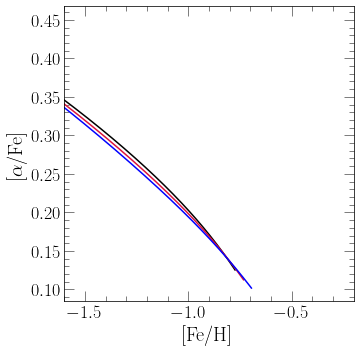

In [3]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_xlabel("[Fe/H]")
ax.set_ylabel(r"[$\alpha$/Fe]")
vice.yields.ccsne.settings['o'] = 0.01
vice.yields.sneia.settings['o'] = 0
vice.yields.ccsne.settings['fe'] = 0.0008
vice.yields.sneia.settings['fe'] = 0.0011
ax.set_xlim([-1.6, -0.2])
# ax.set_ylim([-0.2, 0.5])

def ifr(t):
    return 1e6 * np.exp(-t / 2)

for yfeia in [0.001, 0.0011, 0.0012]:
    vice.yields.sneia.settings['fe'] = yfeia
    colors = {
        0.001: "black",
        0.0011: "crimson",
        0.0012: "blue"
    }
    eta = {
        0.001: 11,
        0.0011: 10,
        0.0012: 9
    }
    with vice.singlezone(name = "test") as sz:
        sz.mode = "ifr"
        sz.func = ifr
        sz.tau_star = 15
        sz.eta = eta[yfeia]
        out = sz.run(np.linspace(0, 5, 1001), overwrite = True, capture = True)
        ax.plot(out.history["[fe/h]"], out.history["[o/fe]"], c = named_colors()[colors[yfeia]])

plt.tight_layout()
plt.show()

/Users/jamesjohnson/Work/Research/VICErepos/VICE/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: func
  warnings.warn("""\


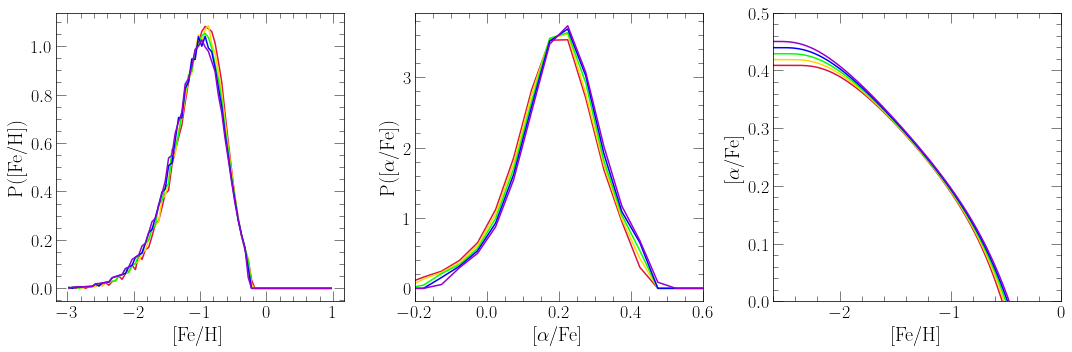

In [6]:
fig = plt.figure(figsize = (15, 5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.set_xlabel("[Fe/H]")
ax1.set_ylabel("P([Fe/H])")
ax2.set_xlabel(r"[$\alpha$/Fe]")
ax2.set_ylabel(r"P([$\alpha$/Fe])")
ax3.set_xlabel("[Fe/H]")
ax3.set_ylabel(r"[$\alpha$/Fe]")
ax2.set_xlim([-0.2, 0.6])
ax3.set_xlim([-2.6, 0])
ax3.set_ylim([0, 0.5])

# tauin = [2, 4, 6, 8, 10]
# eta = [10, 9.5, 9, 8.5, 8]
taustar = [12, 13, 14, 15, 16]
yfecc = [8.8e-4, 8.6e-4, 8.4e-4, 8.2e-4, 8.0e-4]
colors = ["crimson", "gold", "lime", "blue", "darkviolet"]
vice.yields.ccsne.settings['o'] = 0.01
vice.yields.ccsne.settings['fe'] = 0.0008
vice.yields.sneia.settings['o'] = 0
vice.yields.sneia.settings['fe'] = 0.0011
for i in range(len(taustar)):
    with vice.singlezone(name = "test") as sz:
        vice.yields.ccsne.settings['fe'] = yfecc[i]
        sz.func = exponential(prefactor = 1000)
#         sz.func.timescale = tauin[i]
        sz.func.timescale = 2
#         sz.tau_star = 15
        sz.tau_star = taustar[i]
        sz.eta = 10
        sz.mode = "ifr"
        sz.Mg0 = 0
        out = sz.run(np.linspace(0, 10, 1001), overwrite = True, capture = True)
        xvals = [(a + b) / 2 for a, b in zip(out.mdf["bin_edge_left"], out.mdf["bin_edge_right"])]
        ax1.plot(xvals, out.mdf["dn/d[fe/h]"], c = named_colors()[colors[i]])
        ax2.plot(xvals, out.mdf["dn/d[o/fe]"], c = named_colors()[colors[i]])
        ax3.plot(out.history["[fe/h]"], out.history["[o/fe]"], c = named_colors()[colors[i]])

vice.yields.ccsne.settings['fe'] = 8.0e-4
plt.tight_layout()
plt.show()